In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import numpy as np
import xplt

import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.particle_ref = xt.Particles(p0c=2e9)

In [4]:
n_bends_per_cell = 6
n_cells_par_arc = 3
n_arcs = 3

n_bends = n_bends_per_cell * n_cells_par_arc * n_arcs

## Arc cell

In [5]:
env.vars({
    'l.mq': 0.5,
    'l.mb': 11,
    'angle.mb': 2 * np.pi / n_bends,
    'k0.mb': 'angle.mb / l.mb',
    'kqf': 0.05,
    'kqd': -0.051
})

In [6]:
halfcell = env.new_line(components=[
    env.new_element('drift.1', xt.Drift,      length='l.mq / 2'),
    env.new_element('qf',      xt.Quadrupole, k1='kqf', length='l.mq'),
    env.new_element('drift.2', xt.Drift,      length=0.75),
    env.new_element('mb.1',    xt.Bend,       k0='k0.mb', h='k0.mb', length='l.mb'),
    env.new_element('drift.3', xt.Drift,      length=1.),
    env.new_element('mb.2',    xt.Replica,    parent_name='mb.1'),
    env.new_element('drift.4', xt.Drift,      length=1.),
    env.new_element('mb.3',    xt.Replica,    parent_name='mb.1'),
    env.new_element('drift.5', xt.Drift,      length=0.75),
    env.new_element('qd',      xt.Quadrupole, k1='kqd', length='l.mq'),
    env.new_element('drift.6', xt.Replica,    parent_name='drift.1'),
])
print(f'Arc half-cell length: {halfcell.get_length()}')

Arc half-cell length: 38.0


In [7]:
hcell_left = halfcell.replicate(name='l')
hcell_right = halfcell.replicate(name='r', mirror=True)

cell = env.new_line(components=[
    env.new_element('start', xt.Marker),
    hcell_left,
    env.new_element('mid', xt.Marker),
    hcell_right,
    env.new_element('end', xt.Marker),
])

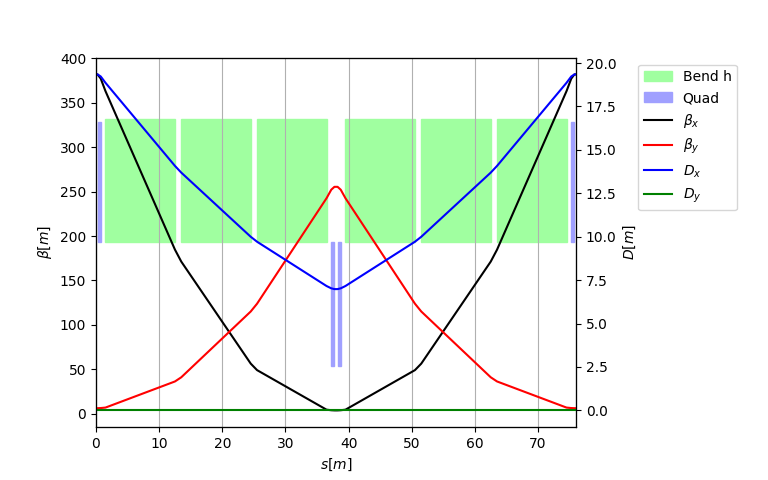

In [8]:
cell.twiss4d().plot()

In [9]:
opt = cell.match(
    method='4d',
    vary=xt.VaryList(['kqf', 'kqd'], step=1e-5),
    targets=xt.TargetSet(
        qx=0.333333,
        qy=0.333333,
    ))
tw_cell = cell.twiss4d()

Matching: model call n. 20               



## Straight section cell

Matching: model call n. 25               

Straight cell length: 76.0


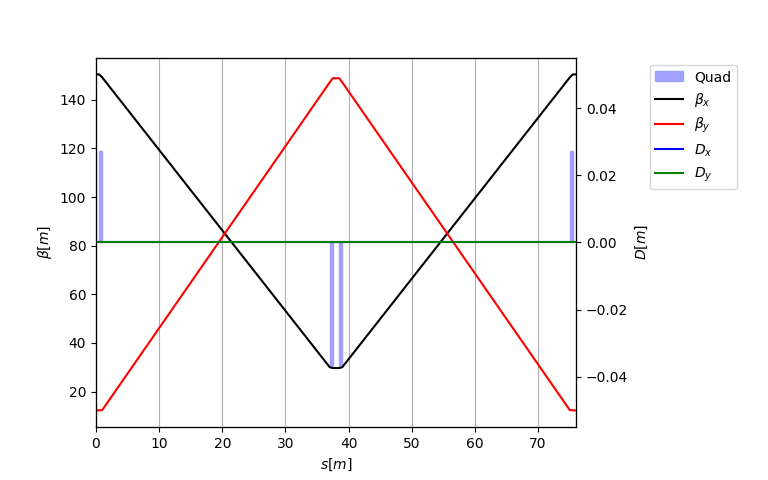

In [10]:
env.vars({
    'k1l.qfss': 0.027 / 2,
    'k1l.qdss': -0.0271 / 2,
    'kqfss.1': 'k1l.qfss / l.mq',
    'kqdss.1': 'k1l.qdss / l.mq',
    'angle.mb': 2 * np.pi / n_bends,
    'k0.mb': 'angle.mb / l.mb',
})
cell_ss = env.new_line(components=[
    env.new_element('ss.start', xt.Marker),
    env.new_element('dd.ss.1.l', xt.Drift,        length='l.mq'),
    env.new_element('qfss.l',    xt.Quadrupole, k1='kqfss.1', length='l.mq'),
    env.new_element('dd.ss.3.l', xt.Drift,        length='3 *l.mb + 3'),
    env.new_element('qdss.l',    xt.Quadrupole, k1='kqdss.1', length='l.mq'),
    env.new_element('dd.ss.5.l', xt.Drift,        length='l.mq'),
    env.new_element('dd.ss.5.r', xt.Drift,        length='l.mq'),
    env.new_element('qdss.r',    xt.Quadrupole, k1='kqdss.1', length='l.mq'),
    env.new_element('dd.ss.3.r', xt.Drift,        length='3 *l.mb + 3'),
    env.new_element('qfss.r',    xt.Quadrupole, k1='kqfss.1', length='l.mq'),
    env.new_element('dd.ss.1.r', xt.Drift,        length='l.mq'),

])

opt = cell_ss.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['k1l.qfss', 'k1l.qdss'], step=1e-5),
    targets=xt.TargetSet(at='ss.start',
        betx=tw_cell.betx[-1],
        bety=tw_cell.bety[-1],
    ))
opt.step(40)
opt.solve()

cell_ss.twiss4d().plot()
print(f'Straight cell length: {cell_ss.get_length()}')

## Make an arc

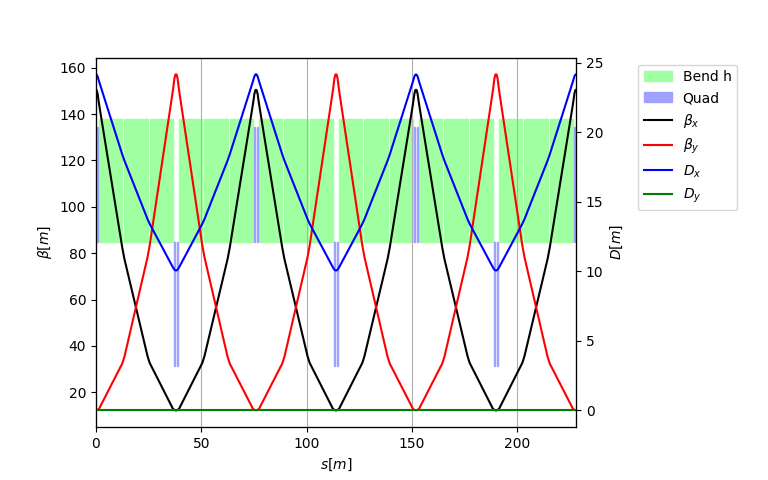

In [11]:
arc = env.new_line(components=[
    cell.replicate(name='cell.1'),
    cell.replicate(name='cell.2'),
    cell.replicate(name='cell.3'),
])
arc.twiss4d().plot()

## Build an straight section

In [12]:
ss = env.new_line(components=[
    cell_ss.replicate('cell.1'),
    cell_ss.replicate('cell.2'),
])

In [13]:
ss.get_length()
cell_ss.get_length()

np.float64(76.0)

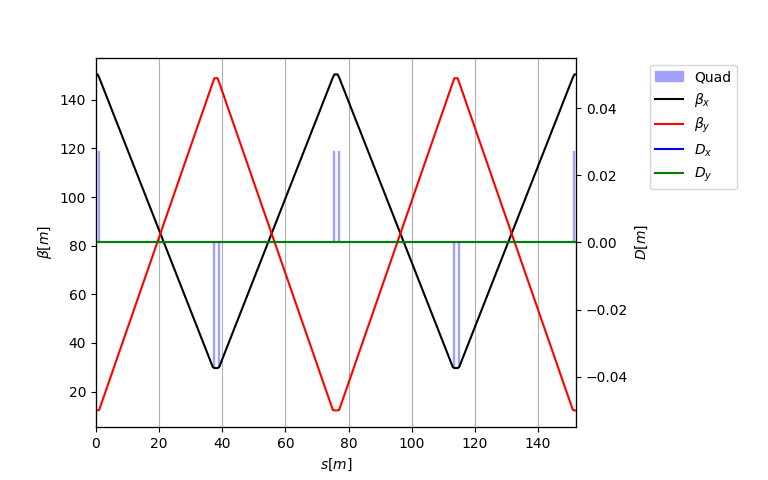

In [14]:
ss.twiss4d().plot()

## Build the ring

In [15]:
ring = env.new_line(components=[
    ss.replicate('ss.1'),
    arc.replicate('arc.1'),
    ss.replicate('ss.2'),
    arc.replicate('arc.2'),
    ss.replicate('ss.3'),
    arc.replicate('arc.3')])    

### Remove replicas

In [16]:
ring.replace_all_replicas()

## Plot geometry

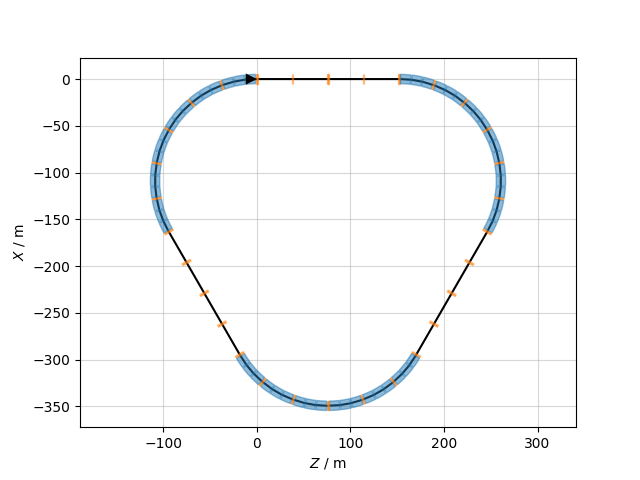

In [17]:
sv = ring.survey()
xplt.FloorPlot(sv, ring, element_width=10)

### Plot optics

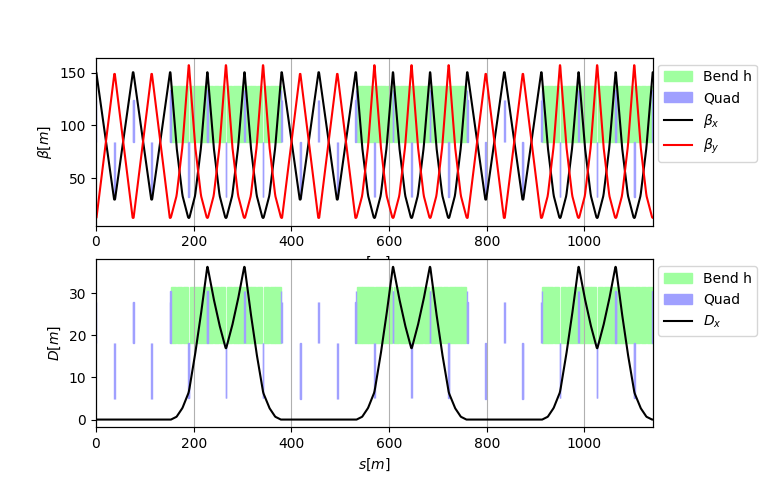

In [18]:
tw = ring.twiss4d()
fig = plt.figure(figsize=(6.4*1.2, 4.8))
ax1 = fig.add_subplot(2, 1, 1)
pltbet = tw.plot('betx bety', ax=ax1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
pltdx = tw.plot('dx', ax=ax2)
fig.subplots_adjust(right=.85)
pltbet.move_legend(1.2,1)
pltdx.move_legend(1.2,1)

## Create a straight section with 40 m long free space (with $\beta_x = \beta_y)$ 

### Layout

In [19]:
env.vars({
    'k1.q1': 0.025,
    'k1.q2': -0.025,
    'k1.q3': 0.025,
    'k1.q4': -0.02,
    'k1.q5': 0.025,
})

half_insertion = env.new_line(components=[
    env.new_element('ip', xt.Marker),
    env.new_element('dd.0', xt.Drift, length=20),
    env.new_element('mq.1', xt.Quadrupole, k1='k1.q1', length='l.mq'),
    env.new_element('dd.1', xt.Drift, length=5),
    env.new_element('mq.2', xt.Quadrupole, k1='k1.q2', length='l.mq'),
    env.new_element('dd.2', xt.Drift, length=12),
    env.new_element('mq.3', xt.Quadrupole, k1='k1.q3', length='l.mq'),
    env.new_element('dd.3', xt.Drift, length=18),
    env.new_element('mq.4', xt.Quadrupole, k1='k1.q4', length='l.mq'),
    env.new_element('dd.4', xt.Drift, length=18),
    env.new_element('mq.5', xt.Quadrupole, k1='k1.q5', length='l.mq'),
    env.new_element('dd.5', xt.Drift, length=0.5),
    env.new_element('e.insertion', xt.Marker),
])

In [20]:
half_insertion.get_length()

np.float64(76.0)

### Macth optics to have symmetry, round beta in the center and correct interface to adjacient arc

In [21]:
tw_arc = arc.twiss4d()

opt = half_insertion.match(
    solve=False,
    betx=tw_arc.betx[0], bety=tw_arc.bety[0],
    alfx=tw_arc.alfx[0], alfy=tw_arc.alfy[0],
    init_at='e.insertion',
    start='ip', end='e.insertion',
    vary=xt.VaryList(['k1.q1', 'k1.q2', 'k1.q3', 'k1.q4'], step=1e-5),
    targets=[
        xt.TargetSet(alfx=0, alfy=0, at='ip'),
        xt.Target(lambda tw: tw.betx[0] - tw.bety[0], 0),
        xt.Target(lambda tw: tw.betx.max(), xt.LessThan(400)),
        xt.Target(lambda tw: tw.bety.max(), xt.LessThan(400)),
        xt.Target(lambda tw: tw.betx.min(), xt.GreaterThan(2)),
        xt.Target(lambda tw: tw.bety.min(), xt.GreaterThan(2)),
    ]
)

opt.solve()

Matching: model call n. 62               



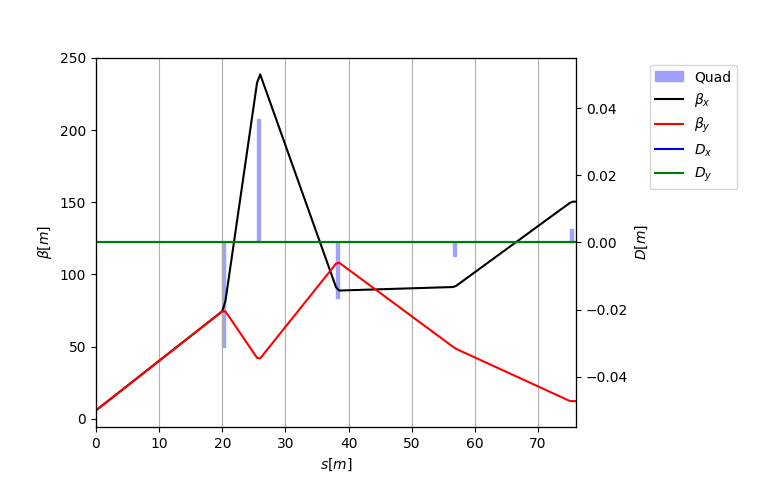

In [22]:
half_insertion.twiss(
    betx=tw_arc.betx[0], bety=tw_arc.bety[0],
    alfx=tw_arc.alfx[0], alfy=tw_arc.alfy[0],
    init_at='e.insertion').plot()

In [23]:
insertion = env.new_line([
    half_insertion.replicate('l', mirror=True),
    half_insertion.replicate('r')])    

In [24]:
ring2 = env.new_line(components=[])
ring2.extend(ss.replicate('ss.1'))
ring2.extend(arc.replicate('arc.1'))
ring2.extend(insertion)
ring2.extend(arc.replicate('arc.2'))
ring2.extend(ss.replicate('ss.3'))
ring2.extend(arc.replicate('arc.3'))

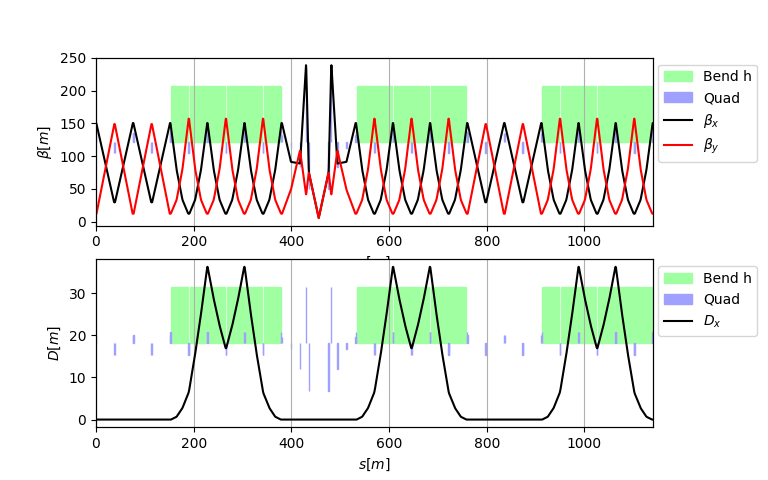

In [25]:
tw = ring2.twiss4d()
fig = plt.figure(figsize=(6.4*1.2, 4.8))
ax1 = fig.add_subplot(2, 1, 1)
pltbet = tw.plot('betx bety', ax=ax1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
pltdx = tw.plot('dx', ax=ax2)
fig.subplots_adjust(right=.85)
pltbet.move_legend(1.2,1)
pltdx.move_legend(1.2,1)

In [26]:
ring2.replace_all_replicas()

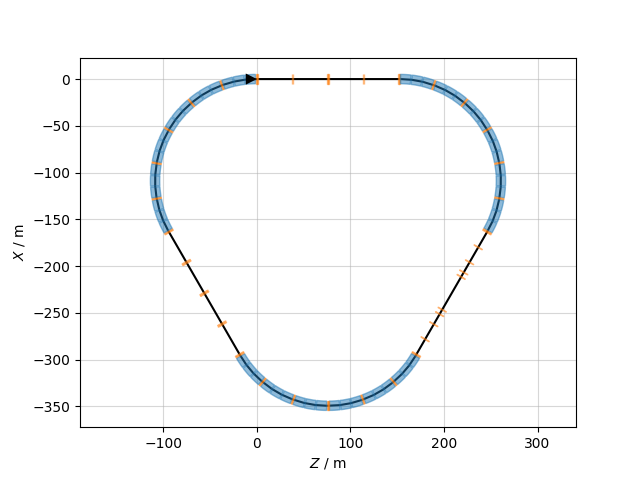

In [27]:
sv = ring2.survey()
xplt.FloorPlot(sv, ring2, element_width=10)